# Optimization

of linear-quadratic problems, using the [OSQP.jl](https://github.com/osqp/OSQP.jl) package.

The optimization problems are (for pedagogical reasons) the same as in the other notebook about optimization. Otherwise, the methods illustrated here are well suited for cases when the objective involves the portfolio variance ($ w'\Sigma w $) or when the estimation problem is based on minimizing the sum of squared residuals ($u'u$), and the restrictions are linear expressions.

## Load Packages and Utility Functions

In [1]:
using Printf, LinearAlgebra, SparseArrays, OSQP

include("jlFiles/printmat.jl");

In [2]:
using Plots, LaTeXStrings    #LaTeXStrings to facilitate using LaTeX in plots

gr(size=(480,320))
default(fmt = :png)

# The OSQP.jl Optimization Package

The [OSQP.jl](https://github.com/osqp/OSQP.jl) package is tailor made for solving linear-quadratic problems (with linear restrictions). It solves problems of the type

$\min 0.5\theta' P \theta + q' \theta$ subject to $l \leq A \theta \leq u$, 

where $\theta$ is a vector of choice variables.

To get an equality restriction in row `i`, set `l[i]=u[i]`.

Notice that $(P,A)$ to should be `Sparse` matrices and $(q,l,u)$ vectors with `Float64` numbers. We consider several cases below: no restrictions on $\theta$, bounds on $\theta$, and a linear equality restriction.

# Unconstrained Minimization

We will define the following minimization problem

$ P=
2\begin{bmatrix}
1 & 0\\
0 & 16\\
\end{bmatrix}
$
and 
$ q = 
\begin{bmatrix}
-4\\
24\\
\end{bmatrix}
$.

If there are no constraints, then the solution should be $\theta=(2,-3/4)$.

It is straightforward to see that this is the same as minimizing 
$ (\theta_1-2)^2 + (4\theta_2+3)^2$


Before doing the optimization, we plot the contours of the loss function.

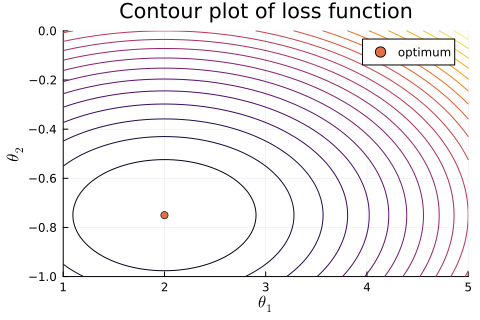

In [3]:
P = 2*[1  0;           #we minimize 0.5θ'Pθ + q'θ, hence the 2*[]
       0  16]          #this is the same as minimizing (x-2)^2 + (4y+3)^2
q =   [-4.0, 24.0]     #vector, Float64

function Lossfn(P,q,θ)
     L = 0.5*θ'*P*θ + q'*θ
    return L
end

(n1,n2) = (82,122)
θ₁ = range(1,5,length=n1)
θ₂ = range(-1,0,length=n2)

loss2d = fill(NaN,n1,n2)      #matrix with loss fn values
for i in 1:n1, j in 1:n2
    loss2d[i,j] = Lossfn(P,q,[θ₁[i],θ₂[j]])
end

p1 = contour( θ₁,θ₂,loss2d',       #notice: loss2d'
              xlims = (1,5),
              ylims = (-1,0),
              legend = false,
              levels = 21,
              title = "Contour plot of loss function",
             xlabel = L"\theta_1",
             ylabel = L"\theta_2" )
scatter!([2],[-0.75],label="optimum",legend=true)
display(p1)

In [4]:
A = zeros(1,2)         #effectively no restriction
l = [0.0]              #vectors, Float64
u = [0.0]

settings = Dict(:verbose => true)
model = OSQP.Model()
OSQP.setup!(model; P=sparse(P), q=q, A=sparse(A), l=l, u=u, settings...)
result = OSQP.solve!(model)

printblue("Unconstrained minimization: the solution should be (2,-3/4):")
printmat(result.x)
printred("\nand lots of information about the iterations:")


Unconstrained minimization: the solution should be (2,-3/4):
     2.000
    -0.750


and lots of information about the iterations:
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2, constraints m = 1
          nnz(P) + nnz(A) = 2
settings: linear system solver = qdldl,
          eps_abs = 1.0e-003, eps_rel = 1.0e-003,
          eps_prim_inf = 1.0e-004, eps_dual_inf = 1.0e-004,
          rho = 1.00e-001 (adaptive),
          sigma = 1.00e-006, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter  objective    pri res    dua res    rho        time
   1 -8.3200e+000  0.00e+000  1.44e+001  

## Constrained Minimization

Bounds on the solution: $2.75 \le \theta_1$ and $\theta_2 \le -0.3$.

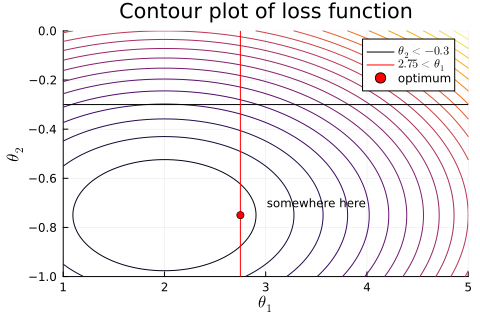

In [5]:
p1 = contour( θ₁,θ₂,loss2d',
              xlims = (1,5),
              ylims = (-1,0),
              legend = false,
              levels = 21,
              title = "Contour plot of loss function",
              xlabel = L"\theta_1",
              ylabel = L"\theta_2",
              annotation = (3.5,-0.7,text("somewhere here",8)) )
hline!([-0.3],linecolor=:black,label=L"\theta_2 < -0.3")
vline!([2.75],linecolor=:red,line=:solid,label=L"2.75 < \theta_1")  
scatter!([2.75],[-0.75],color=:red,label="optimum",legend = true)
display(p1)

In [6]:
A = I[1:2,1:2]     #identity matrix, I₂
l = [2.75,-Inf]    #2.75 <= θ₁ <= Inf, -Inf <= θ₂ <= -0.3
u = [Inf,-0.3]

settings = Dict(:verbose => false)
model = OSQP.Model()
OSQP.setup!(model; P=sparse(P), q=q, A=sparse(A), l=l, u=u, settings...)
result = OSQP.solve!(model)

printblue("with bounds on the solution: the solution should be (2.75,-0.75):")
printmat(result.x)

with bounds on the solution: the solution should be (2.75,-0.75):
     2.750
    -0.750



## Constrained Minimization

A linear equality constraint: $\theta_1 + 2\theta_2 = 3$.

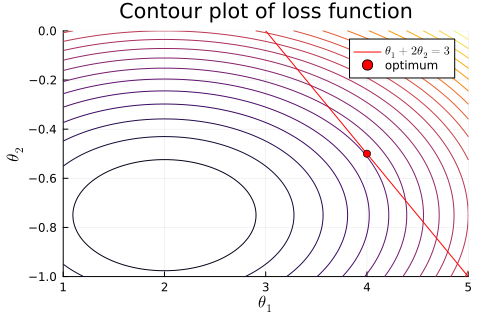

In [7]:
p1 = contour(θ₁,θ₂,loss2d',
             xlims = (1,5),
             ylims = (-1,0),
             legend = false,
             levels = 21, 
             title = "Contour plot of loss function",
             xlabel = L"\theta_1",
             ylabel = L"\theta_2" )
Plots.abline!(-0.5,1.5,linecolor=:red,line=:solid,label=L"\theta_1+2\theta_2=3")
scatter!([4],[-0.5],markercolor=:red,label="optimum",legend=true)
display(p1)

In [8]:
A = [1 2]                    #equality constraint
l = [3.0]
u = [3.0]

model = OSQP.Model()
OSQP.setup!(model; P=sparse(P), q=q, A=sparse(A), l=l, u=u, settings...)
result = OSQP.solve!(model)

printblue("equality constraint: the solution should be (4,-1/2):\n")
printmat(result.x)

equality constraint: the solution should be (4,-1/2):

     4.000
    -0.500



# Updating the Problem (extra)

When you just want to change some of the inputs to the optimization problem, then it may pay off to do `update!()`. This is especially useful when you resolve the problem many times (in a loop, say).

In [9]:
model = OSQP.Model()                #setting up the problem for the first time
OSQP.setup!(model; P=sparse(P), q=q, A=sparse(A), l=l, u=u, settings...)
result = OSQP.solve!(model)
printmat(result.x)

q_new = [-2.0,20.0]                 #resolve the problem with different q values
OSQP.update!(model;q=q_new)         #(partially) update the problem      
result = OSQP.solve!(model)
printmat(result.x)

     4.000
    -0.500

     3.600
    -0.300



# An Alternative Package (extra)

The [Clarabel.jl](https://github.com/oxfordcontrol/Clarabel.jl) package is an interesting alternative to OSQP.jl. It has a slightly different syntax, but the `DoClarabel()` function in `jlFiles/DoClarabel.jl` provides a way to call it using the same syntax as for OSQP.jl.

In [10]:
using LinearAlgebra, SparseArrays, Clarabel
include("jlFiles/DoClarabel.jl");

In [11]:
(x,result,fnO) = DoClarabel(P,q,A,l,u,Clarabel.Settings(verbose = false))
printblue("equality constraint: the solution should be (4,-1/2), as before:")
printmat(x)

equality constraint: the solution should be (4,-1/2), as before:
     4.000
    -0.500

